In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import math
from sklearn.preprocessing import MinMaxScaler
# Loading the Apple.Inc Stock Data

import yfinance as yf
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
https://www.kaggle.com/code/jillanisofttech/amazon-stock-price-predication-using-lstm-and-rnn

# Zadanie 1 - airline-passengers.csv

In [90]:
df_airline = pd.read_csv('/content/airline-passengers.csv')

timeseries = df_airline[["Passengers"]].values.astype('float32')

train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(f"Shape of X_train {X_train.shape}")
print(f"Shape of y_train {y_train.shape}")
print(f"Shape of X_test {X_test.shape}")
print(f"Shape of y_test {y_test.shape}")

Shape of X_train torch.Size([92, 4, 1])
Shape of y_train torch.Size([92, 4, 1])
Shape of X_test torch.Size([44, 4, 1])
Shape of y_test torch.Size([44, 4, 1])


In [91]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

In [92]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.layer_norm(out)
        out = self.fc(out)
        # out = nn.functional.relu(out)  # Dodanie funkcji aktywacji ReLU
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.layer_norm(out)
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.layer_norm(out)
        out = self.fc(out)
        return out

In [93]:
rnn_model = SimpleRNNModel(input_size=1, hidden_size=64, output_size=1)
rnn_criterion = nn.MSELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

In [94]:
lstm_model = LSTMModel(input_size=1, hidden_size=50, output_size=1, num_layers=1)
lstm_criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [95]:
gru_model = GRUModel(input_size=1, hidden_size=32, output_size=1, num_layers=2)
gru_criterion = nn.MSELoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

In [96]:
def train_and_evaluate(epochs, model, criterion, optimizer):
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
  for epoch in range(epochs):
      model.train()
      for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          # print("Shape of y_pred:", y_pred.shape)
          # print("Shape of y_batch:", y_batch.shape)
          loss = criterion(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      if epoch % 100 != 0:
          continue
      model.eval()
      with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(criterion(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(criterion(y_pred, y_test))
      print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

  with torch.no_grad():
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, :]
      train_plot[lookback:train_size] = model(X_train)[:, -1, :]
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
  plt.plot(timeseries)
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  plt.show()

Epoch 0: train RMSE 225.3347, test RMSE 424.6616
Epoch 100: train RMSE 58.7517, test RMSE 212.1651
Epoch 200: train RMSE 45.6367, test RMSE 175.3819
Epoch 300: train RMSE 35.8743, test RMSE 145.6957
Epoch 400: train RMSE 27.5621, test RMSE 124.7967
Epoch 500: train RMSE 23.7886, test RMSE 100.4299
Epoch 600: train RMSE 20.8522, test RMSE 86.8875
Epoch 700: train RMSE 19.9102, test RMSE 79.4228
Epoch 800: train RMSE 19.6118, test RMSE 74.1054
Epoch 900: train RMSE 19.0472, test RMSE 71.8801
Epoch 1000: train RMSE 18.6158, test RMSE 72.9131
Epoch 1100: train RMSE 18.6738, test RMSE 75.3611
Epoch 1200: train RMSE 18.4218, test RMSE 72.3452
Epoch 1300: train RMSE 18.1470, test RMSE 70.3066
Epoch 1400: train RMSE 18.9269, test RMSE 66.6696
Epoch 1500: train RMSE 18.5061, test RMSE 74.5587
Epoch 1600: train RMSE 17.7892, test RMSE 73.8632
Epoch 1700: train RMSE 17.9850, test RMSE 68.6727
Epoch 1800: train RMSE 17.4832, test RMSE 74.7686
Epoch 1900: train RMSE 17.5083, test RMSE 74.0293


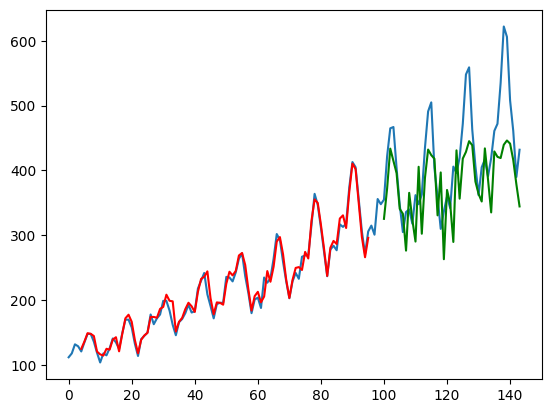

In [97]:
train_and_evaluate(epochs=2000,
                   model=rnn_model,
                   criterion=rnn_criterion,
                   optimizer=rnn_optimizer)

Epoch 0: train RMSE 224.6448, test RMSE 423.8713
Epoch 100: train RMSE 62.1767, test RMSE 224.9172
Epoch 200: train RMSE 28.4328, test RMSE 138.8236
Epoch 300: train RMSE 23.6753, test RMSE 105.6057
Epoch 400: train RMSE 22.7914, test RMSE 94.4626
Epoch 500: train RMSE 21.3879, test RMSE 85.2254
Epoch 600: train RMSE 22.1387, test RMSE 86.7855
Epoch 700: train RMSE 21.5169, test RMSE 79.9586
Epoch 800: train RMSE 20.8374, test RMSE 79.1052
Epoch 900: train RMSE 22.9117, test RMSE 75.0166
Epoch 1000: train RMSE 21.0658, test RMSE 80.1602
Epoch 1100: train RMSE 20.5290, test RMSE 82.8180
Epoch 1200: train RMSE 20.2228, test RMSE 74.3988
Epoch 1300: train RMSE 20.6356, test RMSE 86.0826
Epoch 1400: train RMSE 20.4498, test RMSE 76.7652
Epoch 1500: train RMSE 19.8712, test RMSE 75.4341
Epoch 1600: train RMSE 19.2979, test RMSE 75.8637
Epoch 1700: train RMSE 20.1644, test RMSE 75.6233
Epoch 1800: train RMSE 20.5309, test RMSE 75.3522
Epoch 1900: train RMSE 19.3733, test RMSE 73.1239


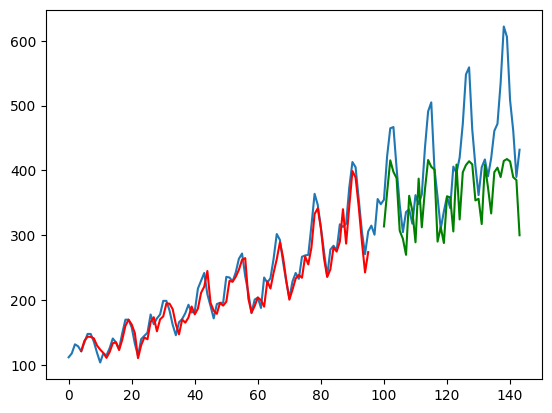

In [98]:
train_and_evaluate(epochs=2000,
                   model=lstm_model,
                   criterion=lstm_criterion,
                   optimizer=lstm_optimizer)

Epoch 0: train RMSE 223.9614, test RMSE 423.0870
Epoch 100: train RMSE 84.0566, test RMSE 262.5924
Epoch 200: train RMSE 32.9411, test RMSE 159.4537
Epoch 300: train RMSE 25.1688, test RMSE 119.8714
Epoch 400: train RMSE 22.8509, test RMSE 102.8769
Epoch 500: train RMSE 21.4690, test RMSE 93.6090
Epoch 600: train RMSE 21.2079, test RMSE 93.1368
Epoch 700: train RMSE 20.7478, test RMSE 90.3029
Epoch 800: train RMSE 21.3942, test RMSE 93.6632
Epoch 900: train RMSE 20.2521, test RMSE 93.0838
Epoch 1000: train RMSE 19.5232, test RMSE 91.8465
Epoch 1100: train RMSE 19.5297, test RMSE 95.5645
Epoch 1200: train RMSE 18.8394, test RMSE 95.2814
Epoch 1300: train RMSE 18.4282, test RMSE 93.8124
Epoch 1400: train RMSE 19.2292, test RMSE 96.0971
Epoch 1500: train RMSE 18.5270, test RMSE 92.1488
Epoch 1600: train RMSE 18.4757, test RMSE 93.9278
Epoch 1700: train RMSE 17.7935, test RMSE 95.8789
Epoch 1800: train RMSE 18.1631, test RMSE 92.1488
Epoch 1900: train RMSE 17.7346, test RMSE 94.1508


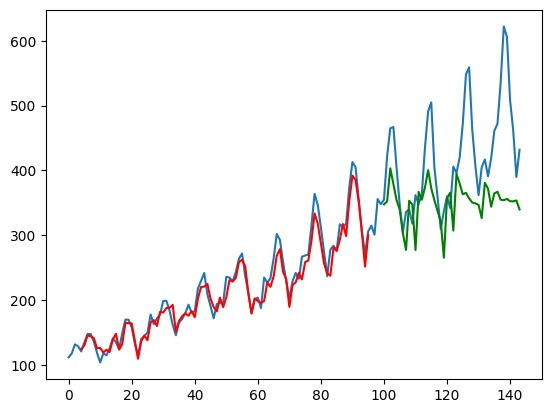

In [99]:
train_and_evaluate(epochs=2000,
                   model=gru_model,
                   criterion=gru_criterion,
                   optimizer=gru_optimizer)

# Zadanie 2 - Apple, Google, Amazon Stock Data

In [85]:
end_date = '2022-01-01'
start_date = '2020-01-01'

df_APPL = yf.download('AAPL', start=start_date, end=end_date)# Function used to fetch the data
df_GOOG = yf.download('GOOG', start=start_date, end=end_date)# Function used to fetch the data
df_AMZN = yf.download('AMZN', start=start_date, end=end_date)# Function used to fetch the data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [86]:
def data_plot(df):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

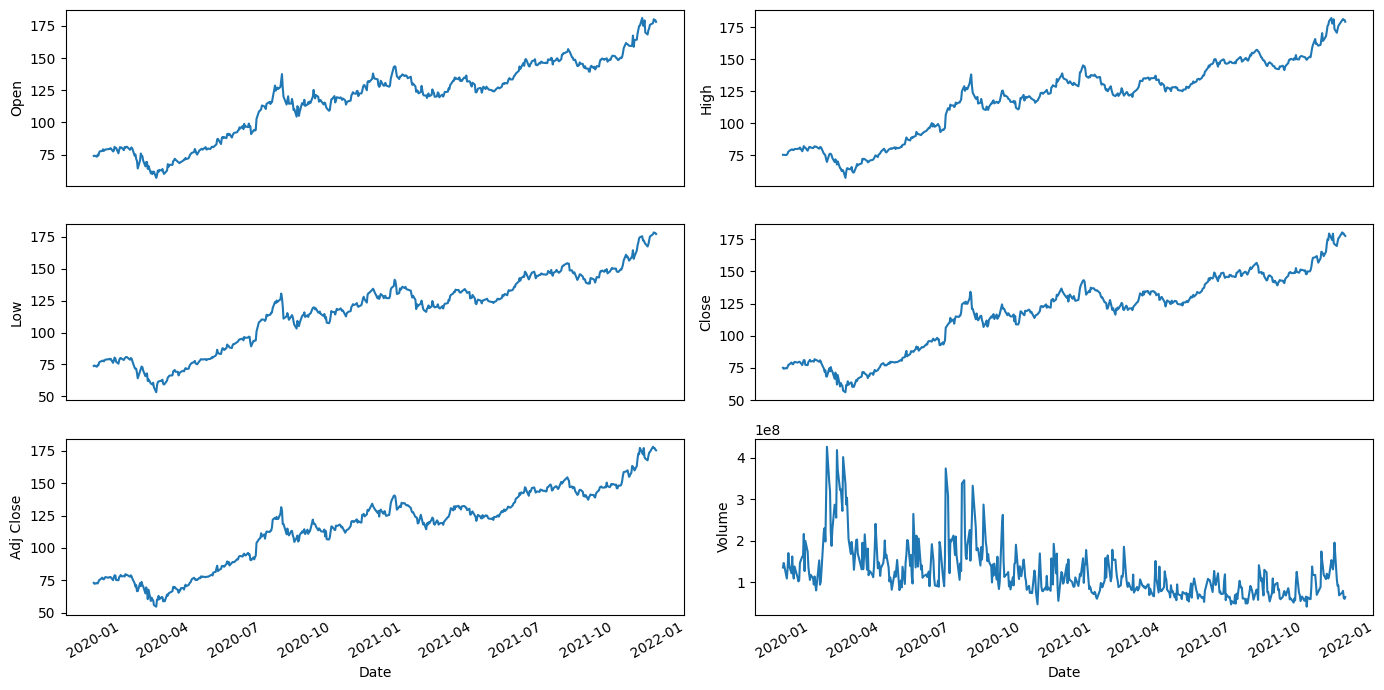

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059418,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925621,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750259,132079200
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.065659,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.038681,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,177.127609,62348900


In [87]:
data_plot(df_APPL)
df_APPL

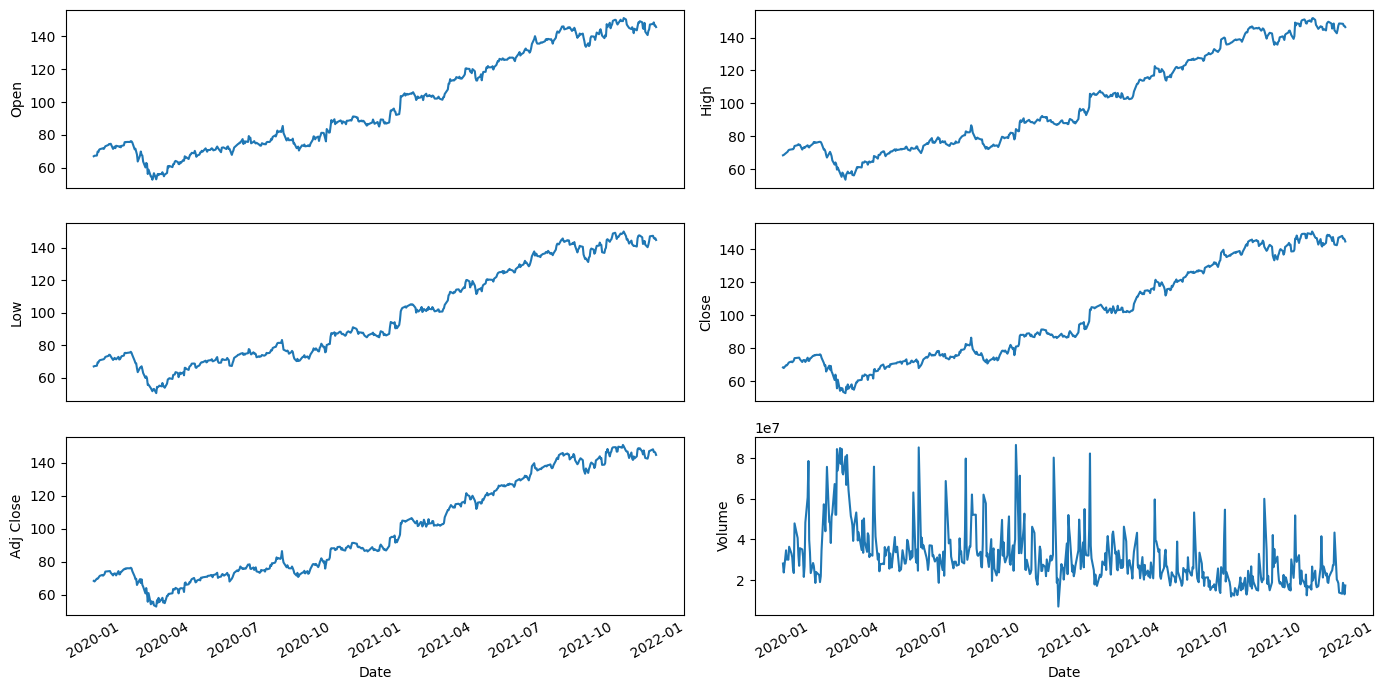

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000
...,...,...,...,...,...,...
2021-12-27,147.463501,148.426498,147.250000,148.063995,148.063995,13256000
2021-12-28,148.374496,148.374496,145.935501,146.447998,146.447998,18624000
2021-12-29,146.429504,147.183746,145.504501,146.504501,146.504501,17022000


In [88]:
data_plot(df_GOOG)
df_GOOG

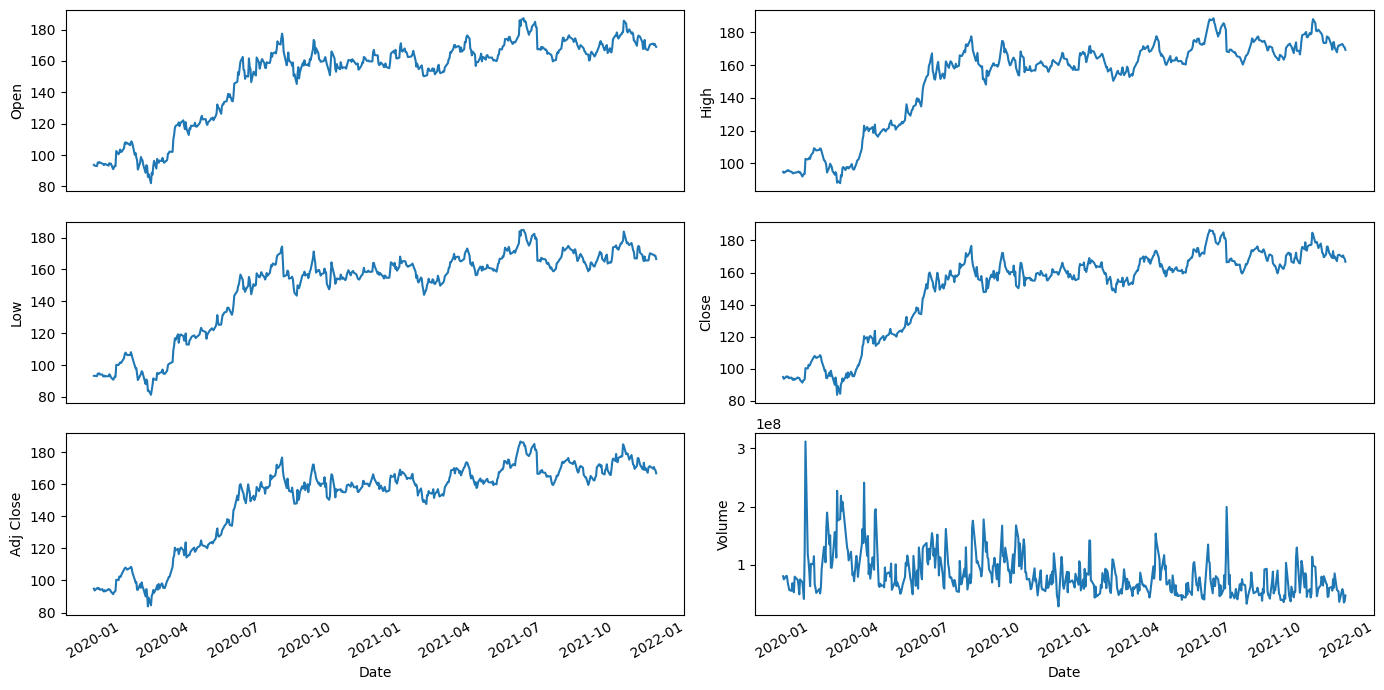

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000
...,...,...,...,...,...,...
2021-12-27,171.037003,172.942993,169.215500,169.669495,169.669495,58688000
2021-12-28,170.182495,172.175995,169.135498,170.660995,170.660995,54638000
2021-12-29,170.839996,171.212006,168.600494,169.201004,169.201004,35754000


In [89]:
data_plot(df_AMZN)
df_AMZN

In [44]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,  num_layers, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size1 = hidden_size
        self.hidden_size2 = hidden_size

        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)

        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        h1 = torch.zeros(1, batch_size, self.hidden_size1).to(x.device)
        h2 = torch.zeros(1, batch_size, self.hidden_size2).to(x.device)

        out1, _ = self.rnn1(x, h0)
        out2, _ = self.rnn2(out1, h1)

        out1 = self.layer_norm1(out1)
        out2 = self.layer_norm2(out2)

        out = self.fc(out2)

        return out


In [45]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size, hidden_size, batch_first=True)])
        for _ in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        out = x
        for lstm_layer in self.lstm_layers:
            out, _ = lstm_layer(out, (h0, c0))
            out = self.layer_norm(out)
            # out = self.dropout(out)

        # Apply output layer to each time step
        out = self.fc(out)
        return out

In [46]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru_layers = nn.ModuleList([nn.GRU(input_size, hidden_size, batch_first=True)])

        for _ in range(num_layers - 1):
            self.gru_layers.append(nn.GRU(hidden_size, hidden_size, batch_first=True))

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)

        out = x
        for gru_layer in self.gru_layers:
            out, _ = gru_layer(out, h0)
            # out = self.layer_norm(out)
            # out = self.dropout(out)

        # Wybierz ostatnią wartość wyjściową dla prognozy dla każdej instancji danych
        out = out[:, :, :]
        out = self.fc(out)
        return out

In [47]:
def prepare_data(df, sq_len_train, sq_len_test):
  training_data_length = math.ceil(len(df) * 0.8)

  training_data = df.iloc[:training_data_length, :1]
  testing_data = df.iloc[training_data_length:, :1]

  print("Shape of training data:", training_data.shape)
  print("Shape of testing data:", testing_data.shape)

  training_data_open = training_data.Open.values.reshape(-1, 1)
  testing_data_open = testing_data.Open.values.reshape(-1, 1)

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_training_data = scaler.fit_transform(training_data_open)
  scaled_testing_data = scaler.transform(testing_data_open)

  print("Shape of scaled training data:", scaled_training_data.shape)
  print("Shape of scaled testing data:", scaled_testing_data.shape)

  # sequence_length = 50

  X_train, y_train = [], []
  for i in range(len(scaled_training_data) - sq_len_train):
      X_train.append(scaled_training_data[i:i+sq_len_train])
      y_train.append(scaled_training_data[i+1:i+sq_len_train+1])

  X_train, y_train = np.array(X_train), np.array(y_train)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)

  print("Shape of X_train:", X_train.shape)
  print("Shape of y_train:", y_train.shape)

  # sequence_length = 10
  X_test, y_test = [], []
  for i in range(len(scaled_testing_data) - sq_len_test):
      X_test.append(scaled_testing_data[i:i+sq_len_test])
      y_test.append(scaled_testing_data[i+1:i+sq_len_test+1])
  X_test, y_test = np.array(X_test), np.array(y_test)

  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)
  print("Shape of X_test:", X_test.shape)
  print("Shape of y_test:", y_test.shape)

  batch_size = 16
  train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return X_train, y_train, X_test, y_test, train_loader, test_loader

In [48]:
def train_and_evaluate(epochs, model, criterion, optimizer,  X_train, y_train, X_test, y_test, train_loader, test_loader):
    best_test_loss = float('inf')
    counter = 0
    patience = 10
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 100 != 0:
            continue

        model.eval()
        with torch.no_grad():
            train_rmse = evaluate_model(model, criterion, X_train, y_train)
            test_rmse = evaluate_model(model, criterion, X_test, y_test)

        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

        # Early stopping based on test loss
#         if test_rmse < best_test_loss:
#             best_test_loss = test_rmse
#             counter = 0
#         else:
#             counter += 1
#         if counter >= patience:
#             print(f'Early stopping after epoch {epoch}.')
#             break

    plot_results(model, X_train, X_test, y_train, y_test)

def evaluate_model(model, criterion, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        rmse = np.sqrt(criterion(y_pred, y))
    return rmse

def plot_results(model, X_train, X_test, y_train, y_test):
    with torch.no_grad():
        train_plot = np.ones_like(y_train) * np.nan
        train_pred = model(X_train)
        train_plot = train_pred[:, -1, 0].detach().numpy()

        test_plot = np.ones_like(y_test) * np.nan
        test_pred = model(X_test)
        test_plot = test_pred[:, -1, 0].detach().numpy()
    x_concat = np.concatenate((np.arange(len(y_train)), np.arange(len(y_train), len(y_train) + len(y_test))))
    y_concat = np.concatenate((y_train[:, -1, 0], y_test[:, -1, 0]))
    plt.plot(x_concat, y_concat, label='True Data')
    plt.plot(np.arange(len(train_plot)), train_plot, label='Train Predictions', c='r', linestyle='--')
    plt.plot(np.arange(len(train_plot), len(train_plot) + len(test_plot)), test_plot, label='Test Predictions', c='g', linestyle='--')
    plt.legend()
    plt.show()

In [49]:
X_train_apple, y_train_apple, X_test_apple, y_test_apple, train_loader_apple, test_loader_apple = prepare_data(df_APPL, 20, 10)

model_rnn_apple = RNNModel(input_size=1, hidden_size=10, output_size=1, num_layers=2, dropout_prob=0.5)
criterion_rnn_apple = nn.MSELoss()
optimizer_rnn_apple = optim.Adam(model_rnn_apple.parameters(), lr=0.001)

model_lstm_apple = LSTMModel(input_size=1, hidden_size=8, output_size=1, num_layers=1, dropout_prob=0.5)
criterion_lstm_apple = nn.MSELoss()
optimizer_lstm_apple = optim.Adam(model_lstm_apple.parameters(), lr=0.001)

model_gru_apple = GRUModel(input_size=1, hidden_size=10, output_size=1, num_layers=1, dropout_prob=0.5)
criterion_gru_apple = nn.MSELoss()
optimizer_gru_apple = optim.Adam(model_gru_apple.parameters(), lr=0.001)

Shape of training data: (404, 1)
Shape of testing data: (101, 1)
Shape of scaled training data: (404, 1)
Shape of scaled testing data: (101, 1)
Shape of X_train: torch.Size([384, 20, 1])
Shape of y_train: torch.Size([384, 20, 1])
Shape of X_test: torch.Size([91, 10, 1])
Shape of y_test: torch.Size([91, 10, 1])


Epoch 0: train RMSE 0.2629, test RMSE 0.3753
Epoch 100: train RMSE 0.0282, test RMSE 0.0526
Epoch 200: train RMSE 0.0281, test RMSE 0.0445
Epoch 300: train RMSE 0.0277, test RMSE 0.0416
Epoch 400: train RMSE 0.0286, test RMSE 0.0391
Epoch 500: train RMSE 0.0277, test RMSE 0.0382
Epoch 600: train RMSE 0.0281, test RMSE 0.0391
Epoch 700: train RMSE 0.0287, test RMSE 0.0355
Epoch 800: train RMSE 0.0275, test RMSE 0.0418
Epoch 900: train RMSE 0.0273, test RMSE 0.0427


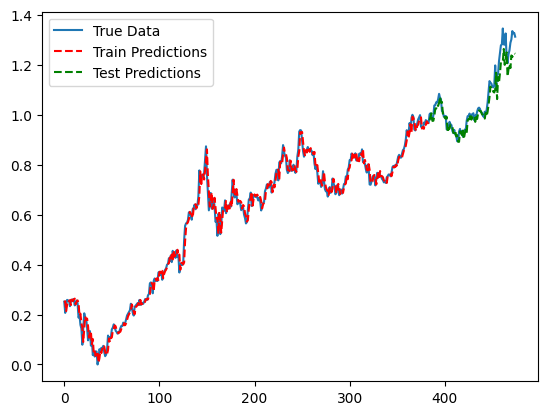

In [50]:
train_and_evaluate(1000, model_rnn_apple, criterion_rnn_apple, optimizer_rnn_apple, X_train_apple, y_train_apple, X_test_apple, y_test_apple, train_loader_apple, test_loader_apple)

Epoch 0: train RMSE 0.2070, test RMSE 0.4168
Epoch 100: train RMSE 0.0302, test RMSE 0.0636
Epoch 200: train RMSE 0.0288, test RMSE 0.0539
Epoch 300: train RMSE 0.0280, test RMSE 0.0449
Epoch 400: train RMSE 0.0278, test RMSE 0.0410
Epoch 500: train RMSE 0.0276, test RMSE 0.0412
Epoch 600: train RMSE 0.0277, test RMSE 0.0406
Epoch 700: train RMSE 0.0276, test RMSE 0.0391
Epoch 800: train RMSE 0.0277, test RMSE 0.0364
Epoch 900: train RMSE 0.0276, test RMSE 0.0381
Epoch 1000: train RMSE 0.0275, test RMSE 0.0358
Epoch 1100: train RMSE 0.0275, test RMSE 0.0366
Epoch 1200: train RMSE 0.0275, test RMSE 0.0370
Epoch 1300: train RMSE 0.0275, test RMSE 0.0375
Epoch 1400: train RMSE 0.0275, test RMSE 0.0377
Epoch 1500: train RMSE 0.0275, test RMSE 0.0374
Epoch 1600: train RMSE 0.0278, test RMSE 0.0345
Epoch 1700: train RMSE 0.0275, test RMSE 0.0359
Epoch 1800: train RMSE 0.0274, test RMSE 0.0376
Epoch 1900: train RMSE 0.0275, test RMSE 0.0384


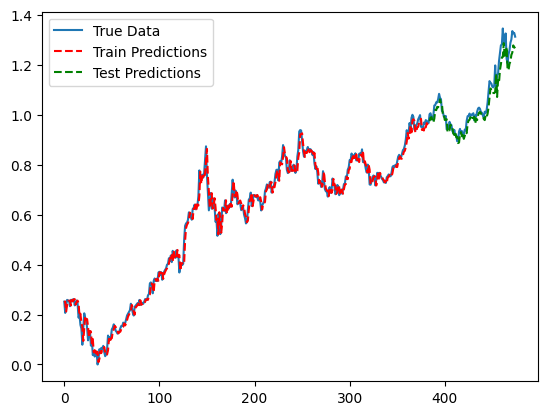

In [51]:
train_and_evaluate(2000, model_lstm_apple, criterion_lstm_apple, optimizer_lstm_apple, X_train_apple, y_train_apple, X_test_apple, y_test_apple, train_loader_apple, test_loader_apple)

Epoch 0: train RMSE 0.5309, test RMSE 1.0011
Epoch 100: train RMSE 0.0311, test RMSE 0.0540
Epoch 200: train RMSE 0.0276, test RMSE 0.0381
Epoch 300: train RMSE 0.0277, test RMSE 0.0347
Epoch 400: train RMSE 0.0274, test RMSE 0.0354
Epoch 500: train RMSE 0.0274, test RMSE 0.0355
Epoch 600: train RMSE 0.0274, test RMSE 0.0350
Epoch 700: train RMSE 0.0275, test RMSE 0.0353
Epoch 800: train RMSE 0.0276, test RMSE 0.0399
Epoch 900: train RMSE 0.0274, test RMSE 0.0390


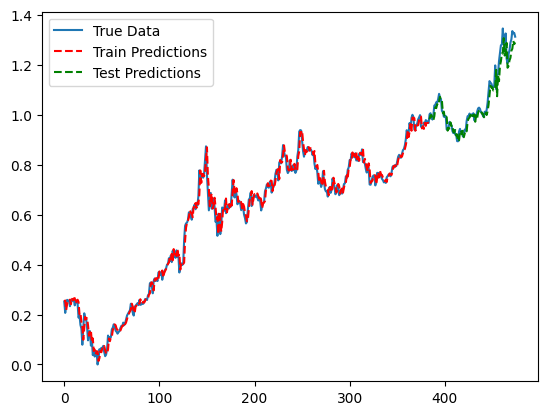

In [52]:
train_and_evaluate(1000, model_gru_apple, criterion_gru_apple, optimizer_gru_apple, X_train_apple, y_train_apple, X_test_apple, y_test_apple, train_loader_apple, test_loader_apple)

In [53]:
X_train_google, y_train_google, X_test_google, y_test_google, train_loader_google, test_loader_google = prepare_data(df_GOOG, 50, 10)

model_rnn_google = RNNModel(input_size=1, hidden_size=10, output_size=1, num_layers=2, dropout_prob=0.5)
criterion_rnn_google = nn.MSELoss()
optimizer_rnn_google = optim.Adam(model_rnn_google.parameters(), lr=0.01)

model_lstm_google = LSTMModel(input_size=1, hidden_size=8, output_size=1, num_layers=1, dropout_prob=0.5)
criterion_lstm_google = nn.MSELoss()
optimizer_lstm_google = optim.Adam(model_lstm_google.parameters(), lr=0.001)

model_gru_google = GRUModel(input_size=1, hidden_size=8, output_size=1, num_layers=1, dropout_prob=0.5)
criterion_gru_google = nn.MSELoss()
optimizer_gru_google = optim.Adam(model_gru_google.parameters(), lr=0.001)

Shape of training data: (404, 1)
Shape of testing data: (101, 1)
Shape of scaled training data: (404, 1)
Shape of scaled testing data: (101, 1)
Shape of X_train: torch.Size([354, 50, 1])
Shape of y_train: torch.Size([354, 50, 1])
Shape of X_test: torch.Size([91, 10, 1])
Shape of y_test: torch.Size([91, 10, 1])


Epoch 0: train RMSE 0.1636, test RMSE 0.5167
Epoch 100: train RMSE 0.0195, test RMSE 0.0350
Epoch 200: train RMSE 0.0196, test RMSE 0.0621
Epoch 300: train RMSE 0.0201, test RMSE 0.0823
Epoch 400: train RMSE 0.0197, test RMSE 0.0706
Epoch 500: train RMSE 0.0188, test RMSE 0.1100
Epoch 600: train RMSE 0.0180, test RMSE 0.1506
Epoch 700: train RMSE 0.0186, test RMSE 0.0787
Epoch 800: train RMSE 0.0191, test RMSE 0.1436
Epoch 900: train RMSE 0.0184, test RMSE 0.1563


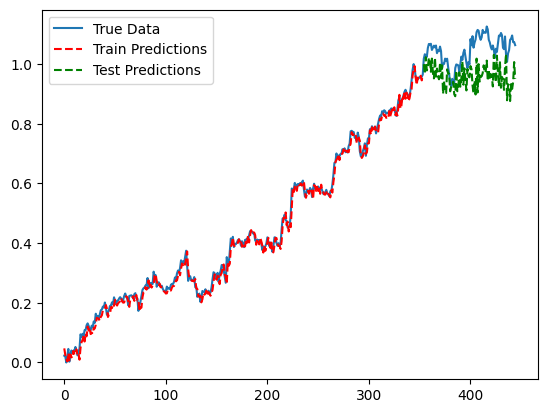

In [54]:
train_and_evaluate(1000, model_rnn_google, criterion_rnn_google, optimizer_rnn_google, X_train_google, y_train_google, X_test_google, y_test_google, train_loader_google, test_loader_google)

Epoch 0: train RMSE 0.0494, test RMSE 0.2287
Epoch 100: train RMSE 0.0194, test RMSE 0.0490
Epoch 200: train RMSE 0.0187, test RMSE 0.0332
Epoch 300: train RMSE 0.0194, test RMSE 0.0336
Epoch 400: train RMSE 0.0191, test RMSE 0.0301
Epoch 500: train RMSE 0.0185, test RMSE 0.0283
Epoch 600: train RMSE 0.0185, test RMSE 0.0297
Epoch 700: train RMSE 0.0186, test RMSE 0.0308
Epoch 800: train RMSE 0.0185, test RMSE 0.0301
Epoch 900: train RMSE 0.0185, test RMSE 0.0320
Epoch 1000: train RMSE 0.0186, test RMSE 0.0324
Epoch 1100: train RMSE 0.0186, test RMSE 0.0331
Epoch 1200: train RMSE 0.0185, test RMSE 0.0325
Epoch 1300: train RMSE 0.0185, test RMSE 0.0335
Epoch 1400: train RMSE 0.0185, test RMSE 0.0335
Epoch 1500: train RMSE 0.0185, test RMSE 0.0355
Epoch 1600: train RMSE 0.0186, test RMSE 0.0418
Epoch 1700: train RMSE 0.0185, test RMSE 0.0453
Epoch 1800: train RMSE 0.0184, test RMSE 0.0435
Epoch 1900: train RMSE 0.0183, test RMSE 0.0434


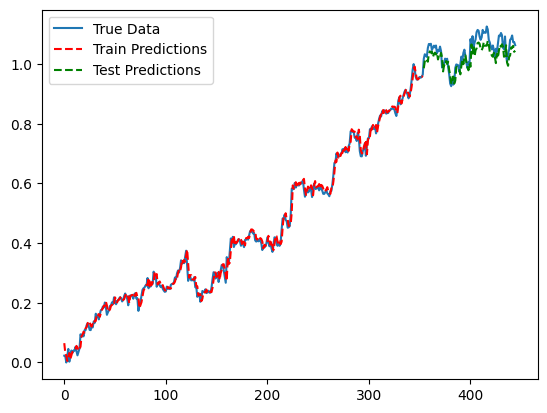

In [55]:
train_and_evaluate(2000, model_lstm_google, criterion_lstm_google, optimizer_lstm_google, X_train_google, y_train_google, X_test_google, y_test_google, train_loader_google, test_loader_google)

Epoch 0: train RMSE 0.4083, test RMSE 0.9191
Epoch 100: train RMSE 0.0222, test RMSE 0.0954
Epoch 200: train RMSE 0.0190, test RMSE 0.0406
Epoch 300: train RMSE 0.0186, test RMSE 0.0261
Epoch 400: train RMSE 0.0186, test RMSE 0.0240
Epoch 500: train RMSE 0.0185, test RMSE 0.0240
Epoch 600: train RMSE 0.0186, test RMSE 0.0226
Epoch 700: train RMSE 0.0185, test RMSE 0.0239
Epoch 800: train RMSE 0.0185, test RMSE 0.0239
Epoch 900: train RMSE 0.0185, test RMSE 0.0232


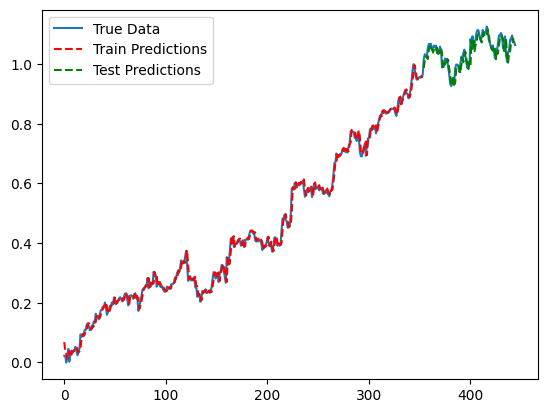

In [56]:
train_and_evaluate(1000, model_gru_google, criterion_gru_google, optimizer_gru_google, X_train_google, y_train_google, X_test_google, y_test_google, train_loader_google, test_loader_google)

In [82]:
X_train_amazon, y_train_amazon, X_test_amazon, y_test_amazon, train_loader_amazon, test_loader_amazon = prepare_data(df_AMZN, 15, 6)

model_rnn_amazon = RNNModel(input_size=1, hidden_size=4, output_size=1, num_layers=1, dropout_prob=0.5)
criterion_rnn_amazon = nn.MSELoss()
optimizer_rnn_amazon = optim.Adam(model_rnn_amazon.parameters(), lr=0.001)

model_lstm_amazon = LSTMModel(input_size=1, hidden_size=10, output_size=1, num_layers=2, dropout_prob=0.5)
criterion_lstm_amazon = nn.MSELoss()
optimizer_lstm_amazon = optim.Adam(model_lstm_amazon.parameters(), lr=0.001)

model_gru_amazon = GRUModel(input_size=1, hidden_size=10, output_size=1, num_layers=2, dropout_prob=0.5)
criterion_gru_amazon = nn.MSELoss()
optimizer_gru_amazon = optim.Adam(model_gru_amazon.parameters(), lr=0.001)

Shape of training data: (404, 1)
Shape of testing data: (101, 1)
Shape of scaled training data: (404, 1)
Shape of scaled testing data: (101, 1)
Shape of X_train: torch.Size([389, 15, 1])
Shape of y_train: torch.Size([389, 15, 1])
Shape of X_test: torch.Size([95, 6, 1])
Shape of y_test: torch.Size([95, 6, 1])


Epoch 0: train RMSE 0.3234, test RMSE 0.4206
Epoch 100: train RMSE 0.0326, test RMSE 0.0244
Epoch 200: train RMSE 0.0303, test RMSE 0.0245
Epoch 300: train RMSE 0.0301, test RMSE 0.0223
Epoch 400: train RMSE 0.0305, test RMSE 0.0253
Epoch 500: train RMSE 0.0299, test RMSE 0.0222
Epoch 600: train RMSE 0.0305, test RMSE 0.0239
Epoch 700: train RMSE 0.0300, test RMSE 0.0239
Epoch 800: train RMSE 0.0296, test RMSE 0.0228
Epoch 900: train RMSE 0.0297, test RMSE 0.0223


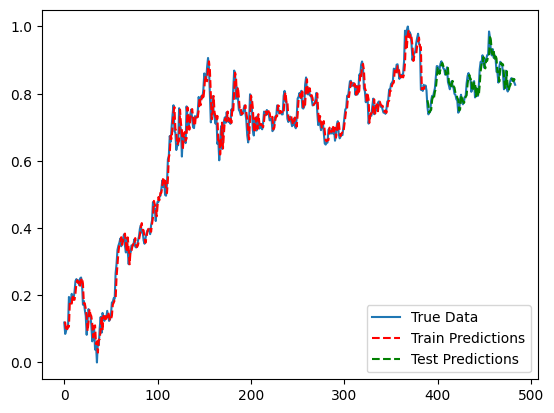

In [75]:
train_and_evaluate(1000, model_rnn_amazon, criterion_rnn_amazon, optimizer_rnn_amazon, X_train_amazon, y_train_amazon, X_test_amazon, y_test_amazon, train_loader_amazon, test_loader_amazon)

Epoch 0: train RMSE 0.1274, test RMSE 0.1295
Epoch 100: train RMSE 0.0312, test RMSE 0.0255
Epoch 200: train RMSE 0.0331, test RMSE 0.0288
Epoch 300: train RMSE 0.0300, test RMSE 0.0225
Epoch 400: train RMSE 0.0299, test RMSE 0.0226
Epoch 500: train RMSE 0.0296, test RMSE 0.0226
Epoch 600: train RMSE 0.0297, test RMSE 0.0238
Epoch 700: train RMSE 0.0294, test RMSE 0.0240
Epoch 800: train RMSE 0.0298, test RMSE 0.0226
Epoch 900: train RMSE 0.0291, test RMSE 0.0228
Epoch 1000: train RMSE 0.0300, test RMSE 0.0251
Epoch 1100: train RMSE 0.0291, test RMSE 0.0236
Epoch 1200: train RMSE 0.0284, test RMSE 0.0242
Epoch 1300: train RMSE 0.0287, test RMSE 0.0242
Epoch 1400: train RMSE 0.0277, test RMSE 0.0237
Epoch 1500: train RMSE 0.0277, test RMSE 0.0246
Epoch 1600: train RMSE 0.0270, test RMSE 0.0236
Epoch 1700: train RMSE 0.0290, test RMSE 0.0265
Epoch 1800: train RMSE 0.0261, test RMSE 0.0241
Epoch 1900: train RMSE 0.0260, test RMSE 0.0247


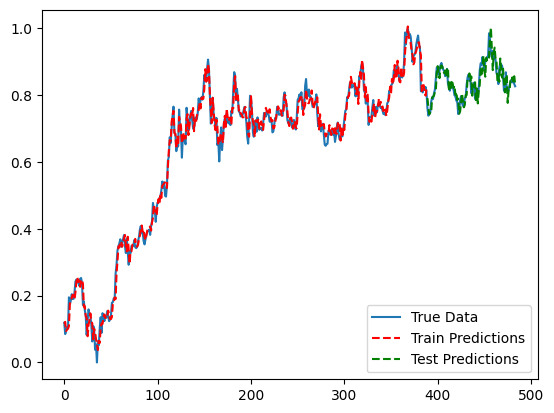

In [83]:
train_and_evaluate(2000, model_lstm_amazon, criterion_lstm_amazon, optimizer_lstm_amazon, X_train_amazon, y_train_amazon, X_test_amazon, y_test_amazon, train_loader_amazon, test_loader_amazon)

Epoch 0: train RMSE 0.7115, test RMSE 0.9719
Epoch 100: train RMSE 0.0308, test RMSE 0.0231
Epoch 200: train RMSE 0.0299, test RMSE 0.0233
Epoch 300: train RMSE 0.0297, test RMSE 0.0225
Epoch 400: train RMSE 0.0300, test RMSE 0.0234
Epoch 500: train RMSE 0.0298, test RMSE 0.0223
Epoch 600: train RMSE 0.0310, test RMSE 0.0261
Epoch 700: train RMSE 0.0298, test RMSE 0.0234
Epoch 800: train RMSE 0.0297, test RMSE 0.0222
Epoch 900: train RMSE 0.0298, test RMSE 0.0225


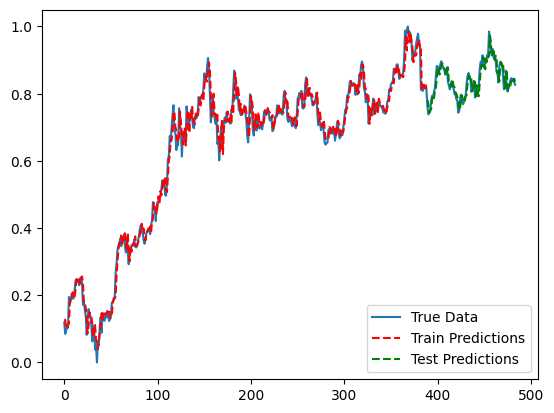

In [84]:
train_and_evaluate(1000, model_gru_amazon, criterion_gru_amazon, optimizer_gru_amazon, X_train_amazon, y_train_amazon, X_test_amazon, y_test_amazon, train_loader_amazon, test_loader_amazon)

# Podsumowanie
W kwestii eksplodującego gradientu jest to zjawisko, które występuje podczas treningu DNN, szczególnie podczas propagacji wstecznej (backpropagation). Polega ono na gwałtownym wzroście wartości gradientów w trakcie propagacji wstecznej, co prowadzi do nadmiernego wzrostu wag modelu. Eksplodujący gradient może wystąpić, gdy wagi modelu są zainicjowane zbyt dużymi wartościami początkowymi lub gdy zbyt duża wartość gradientu jest przekazywana w procesie propagacji wstecznej.
Zapobieganie temu zjawisku głownie przypisuje się normalizacji.
W kwestii parametrów modelu, głównie zmieniane zostały: liczba neuronów w warstwie, liczba warstw, learning rate, oraz bardzo ważny parametr czyli długość sekwencji. Dla powyższych parametrów wyniki były co najmniej zadowalające.
Funckja aktywacja RELU została pominięta ponieważ pogarszała wyniki. Jest to efektem wprowadzenia przez nią nadmiernego zanikania gradientów. Dla bardziej skomplikowanych szeregów czasowych zastosowanie jak najbardziej zalecane: https://ieeexplore.ieee.org/document/9907003
GRU to mniej skomplikowana wersja LSTM, mniejsza złożoność obliczeniowa ale raczej gorsze wyniki. LSTM jest świetne dla modelowania złożonych problemów. RNN to problem zanikającego gradientu i nie radzi sobie z bardziej skomplikowanymi problemami.